# Qiskit Workshop: Quantum Machine Learning

In [9]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-03-21 07:05:16,748: Default instance: ibm-q-asu/internal/reservations


---

## Quantum Kernel Machine Learning

In [11]:
import matplotlib.pyplot as plt
import numpy as np

### Create a dataset

In [12]:
pip install qiskit-machine-learning

Note: you may need to restart the kernel to use updated packages.


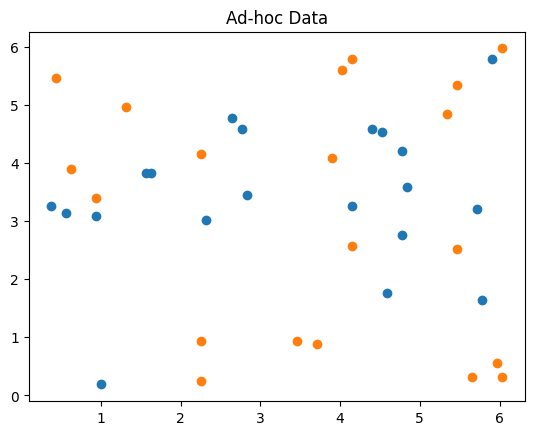

In [13]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=True, one_hot=False, include_sample_total=True
)

## Classical SVM model

In [14]:
from sklearn.svm import SVC

classical_svc = SVC(kernel='poly', degree=3)
classical_svc.fit(train_features, train_labels)
score = classical_svc.score(test_features, test_labels)
score

0.5

## Quantum SVM model

### Create feature map using ```ZZFeatureMap```

In [15]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension,
                                 reps=2, entanglement='linear')

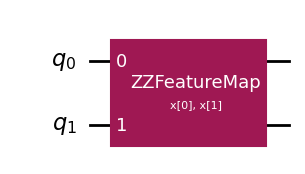

In [16]:
feature_map.draw()

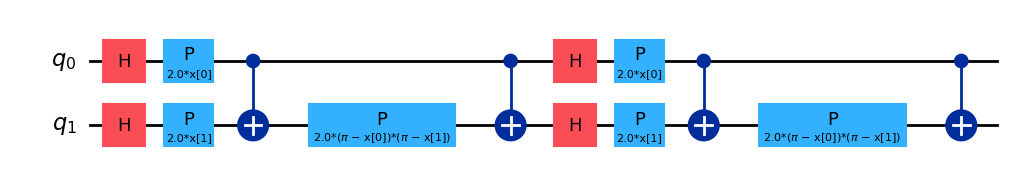

In [17]:
feature_map.decompose().draw()

### Generate a quantum kernel

In [18]:
pip install qiskit-algorithms

Note: you may need to restart the kernel to use updated packages.


In [19]:
import qiskit_algorithms

In [20]:
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler

fidelity = ComputeUncompute(sampler=Sampler())

In [21]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = ZZFeatureMap(2)
new_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

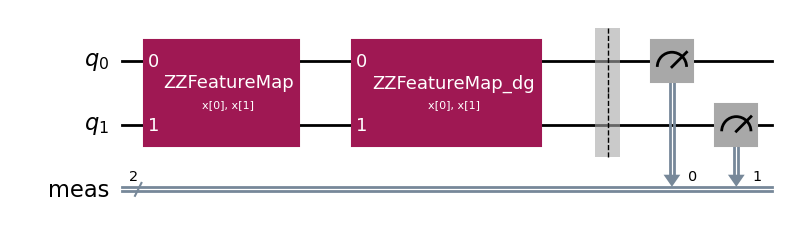

In [22]:
# Circuit for kernel evaluation
fidelity.create_fidelity_circuit(feature_map, feature_map).draw()

### Method A: Use kernel as callable function in `SVC`

In [26]:
from sklearn.svm import SVC

svc = SVC(kernel=new_kernel.evaluate)
svc.fit(train_features, train_labels)
score = svc.score(test_features, test_labels)

print(f'Callable kernel classification test score: {score}')

Callable kernel classification test score: 1.0


### Method B: Precompute kernel matrix

In [33]:
kernel_matrix_train = kernel.evaluate(x_vec=train_features)
kernel_matrix_test = kernel.evaluate(x_vec=test_features, y_vec=train_features)

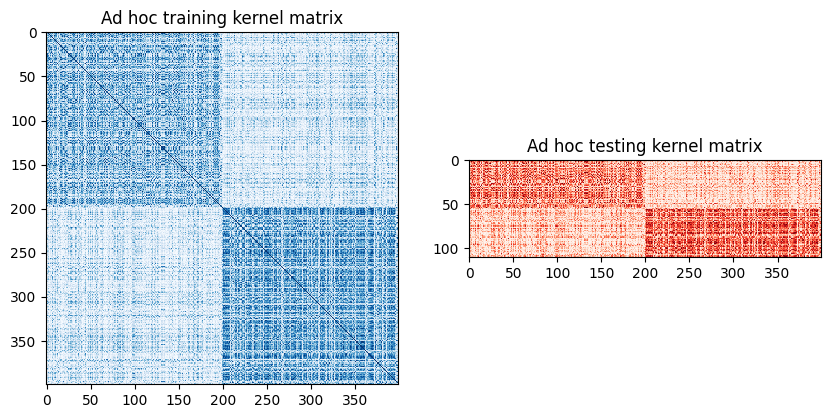

In [34]:
# Plot the kernel matricies
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(kernel_matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(kernel_matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

In [35]:
# Train the sklearn SVM classifier
svc_precomp = SVC(kernel='precomputed')
svc_precomp.fit(kernel_matrix_train, train_labels)
score = svc_precomp.score(kernel_matrix_test, test_labels)

print(f'Precomputed kernel classification test score: {score}')

Precomputed kernel classification test score: 1.0


### Method C: Use Qiskit's `QSVC` class

In [25]:
from qiskit_machine_learning.algorithms import QSVC
qsvc = QSVC(quantum_kernel=new_kernel)
qsvc.fit(train_features, train_labels)
qsvc.score(test_features, test_labels)

1.0



---
## Quantum Neural Networks

### Construct a feature map

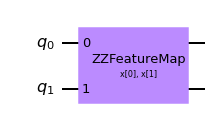

In [16]:
from qiskit.circuit.library import ZZFeatureMap

qnn_feature_map = ZZFeatureMap(adhoc_dimension)
qnn_feature_map.draw()

### Construct an variational "ansatz" circuit

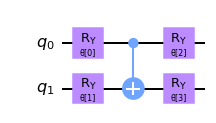

In [17]:
from qiskit.circuit.library import RealAmplitudes

qnn_ansatz = RealAmplitudes(adhoc_dimension, reps=1)
qnn_ansatz.decompose().draw()

### Create a Variational Quantum Classifier ```VQC```

In [18]:
# Plotting function
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

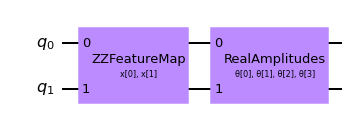

In [19]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import COBYLA

vqc = VQC(feature_map=qnn_feature_map,
          ansatz=qnn_ansatz,
          loss='cross_entropy',
          optimizer=COBYLA(),
          callback=callback_graph)
vqc.circuit.draw()

### Train the VQC

`VQC` class requires labels to be one-hot encoded

In [20]:
def encode_one_hot(y):
    num_samples = y.shape[0]
    one_hot = np.zeros((num_samples, np.max(y)+1))
    for i in range(num_samples):
        one_hot[i, y[i]] = 1
    return one_hot

vqc_train_labels = encode_one_hot(train_labels)
vqc_test_labels = encode_one_hot(test_labels)

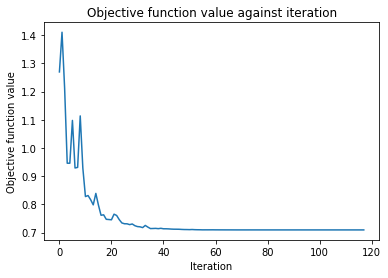

1.0

In [22]:
objective_func_vals = []

# fit classifier to data
vqc.fit(train_features, vqc_train_labels)

vqc.score(test_features, vqc_test_labels)

In [23]:
vqc.score(train_features, vqc_train_labels)

0.8

In [24]:
%qiskit_version_table